In [618]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [619]:
# Load data
data = pd.read_csv('/content/99to21.csv')
interest_data = pd.read_csv('/content/Interest_rate.csv')

In [620]:
# Convert the 'Date' column to datetime format
interest_data['DATE'] = pd.to_datetime(interest_data['DATE'])

# Filter the data for the desired time period (2019-2021)
start_date = pd.to_datetime('1999-10-01')
end_date = pd.to_datetime('2021-06-30')
interest_data = interest_data[(interest_data['DATE'] >= start_date) & (interest_data['DATE'] <= end_date)]


In [621]:
interest_data

,DATE,DFF
0,1999-10-01,5.26
1,1999-10-02,5.26
2,1999-10-03,5.26
3,1999-10-04,5.23
4,1999-10-05,5.16
...,...,...
7939,2021-06-26,0.10
7940,2021-06-27,0.10
7941,2021-06-28,0.10
7942,2021-06-29,0.10


In [622]:
# Decompose the 'Close' column to get the trend, seasonal, and residual components
decomposition = seasonal_decompose(data['Close'], period=365)  # Assuming daily data, adjust 'period' accordingly

In [623]:
data['interest_rate'] = interest_data['DFF']

In [624]:
data['Trend'] = decomposition.trend
data['Seasonal'] = decomposition.seasonal
data['Residual'] = decomposition.resid

# Simple Moving Average (SMA)
data['SMA'] = data['Close'].rolling(window=5).mean()

# Exponential Moving Average (EMA)
data['EMA'] = data['Close'].ewm(span=5, adjust=False).mean()

# Relative Strength Index (RSI)
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).fillna(0)
loss = (-delta.where(delta < 0, 0)).fillna(0)
avg_gain = gain.rolling(window=5).mean()
avg_loss = loss.rolling(window=5).mean()
rs = avg_gain / avg_loss
data['RSI'] = 100 - (100 / (1 + rs))

In [625]:
data.dropna(inplace=True)

In [626]:
data.shape

(5108, 15)

In [627]:
# Splitting the data
split_ratio = 0.8
split_index = int(split_ratio * len(data))

# Features: Close, Trend, Seasonal, Residual, Open, High, Low
features = data[['Open','High','Low','Trend','SMA','EMA']]
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Scaling target
target = np.array(data['Close']).reshape(-1, 1)
scaler_target = MinMaxScaler()
scaled_target = scaler_target.fit_transform(target)

Epoch 1/200
127/127 - 4s - loss: 0.0116 - val_loss: 0.0054 - 4s/epoch - 33ms/step
Epoch 2/200
127/127 - 2s - loss: 0.0024 - val_loss: 0.0029 - 2s/epoch - 17ms/step
Epoch 3/200
127/127 - 2s - loss: 0.0020 - val_loss: 0.0039 - 2s/epoch - 15ms/step
Epoch 4/200
127/127 - 3s - loss: 0.0018 - val_loss: 0.0055 - 3s/epoch - 21ms/step
Epoch 5/200
127/127 - 2s - loss: 0.0017 - val_loss: 6.5798e-04 - 2s/epoch - 18ms/step
Epoch 6/200
127/127 - 2s - loss: 0.0013 - val_loss: 9.1591e-04 - 2s/epoch - 15ms/step
Epoch 7/200
127/127 - 2s - loss: 0.0012 - val_loss: 7.4956e-04 - 2s/epoch - 15ms/step
Epoch 8/200
127/127 - 2s - loss: 0.0012 - val_loss: 7.2028e-04 - 2s/epoch - 15ms/step
Epoch 9/200
127/127 - 2s - loss: 0.0011 - val_loss: 0.0028 - 2s/epoch - 15ms/step
Epoch 10/200
127/127 - 3s - loss: 0.0010 - val_loss: 0.0017 - 3s/epoch - 20ms/step
Epoch 11/200
127/127 - 2s - loss: 0.0010 - val_loss: 6.0191e-04 - 2s/epoch - 18ms/step
Epoch 12/200
127/127 - 2s - loss: 9.2852e-04 - val_loss: 0.0016 - 2s/epoch -

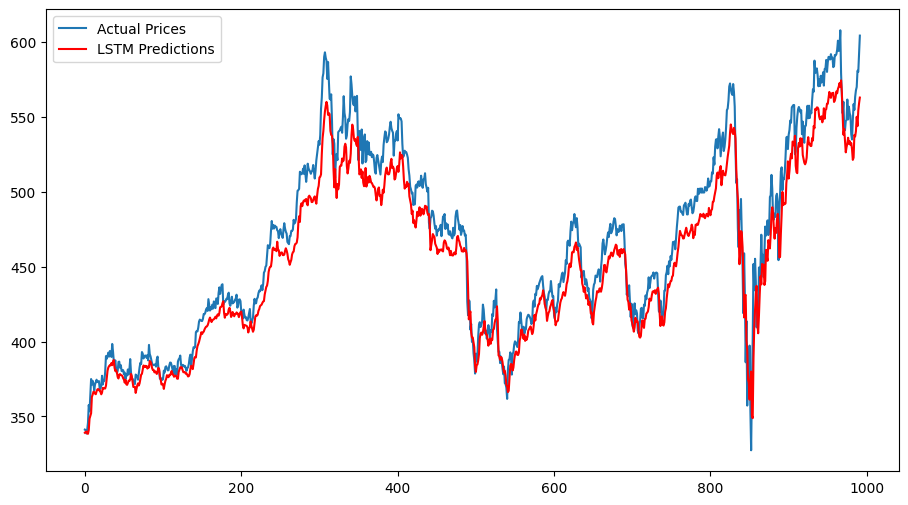

In [628]:

# Sequence creation
sequence_length = 30

def create_sequences(features, target, sequence_length):
    sequences = []
    y_values = []

    for i in range(len(features) - sequence_length):
        sequences.append(features[i:i+sequence_length])
        y_values.append(target[i+sequence_length])

    return np.array(sequences), np.array(y_values)

X_train, y_train = create_sequences(scaled_features[:split_index], scaled_target[:split_index], sequence_length)
X_test, y_test = create_sequences(scaled_features[split_index:], scaled_target[split_index:], sequence_length)

# Modeling with LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, scaled_features.shape[1])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs= 200, batch_size=32, verbose=2, validation_data=(X_test, y_test))

# Predictions and RMSE calculations
predicted_scaled = model.predict(X_test)
predicted = scaler_target.inverse_transform(predicted_scaled)
rmse = np.sqrt(mean_squared_error(scaler_target.inverse_transform(y_test), predicted))
print(f"Root Mean Squared Error (RMSE) for LSTM: {rmse}")

# Actual vs Predicted plot
plt.figure(figsize=(11, 6))
plt.plot(scaler_target.inverse_transform(y_test), label="Actual Prices")
plt.plot(predicted, label="LSTM Predictions", color='red')
plt.legend()
plt.show()


In [629]:
model.save('99to08_my_model_at_atEpochs_200_Highly_correlated_for_covid.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


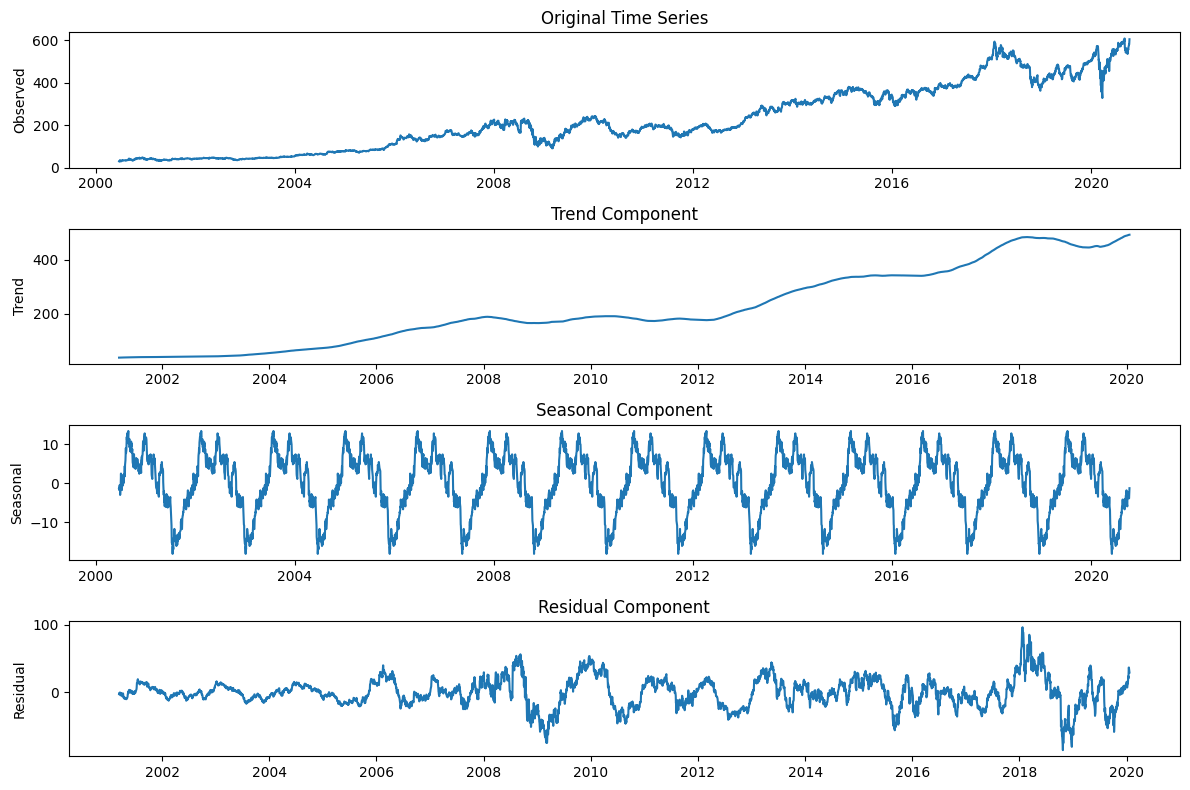

In [630]:
# Plotting the decomposed time series components
plt.figure(figsize=(12, 8))

dates = pd.to_datetime(data['Date'])
prices = data['Close'].values

# Decomposing the time series
# 'freq' parameter might need tuning based on your data's inherent seasonality
result = seasonal_decompose(prices, model='additive', period=365)
plt.subplot(4, 1, 1)
plt.plot(dates, result.observed)
plt.title('Original Time Series')
plt.ylabel('Observed')

plt.subplot(4, 1, 2)
plt.plot(dates, result.trend)
plt.title('Trend Component')
plt.ylabel('Trend')

plt.subplot(4, 1, 3)
plt.plot(dates, result.seasonal)
plt.title('Seasonal Component')
plt.ylabel('Seasonal')

plt.subplot(4, 1, 4)
plt.plot(dates, result.resid)
plt.title('Residual Component')
plt.ylabel('Residual')

plt.tight_layout()
plt.show()

In [631]:
X_train.shape

(4056, 30, 6)

In [632]:
X_test.shape

(992, 30, 6)

In [633]:
data.shape

(5108, 15)

In [634]:
data

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume,interest_rate,Trend,Seasonal,Residual,SMA,EMA,RSI
182,182,2000-06-21,28.500000,29.250000,28.500000,29.250000,18.411955,35700,6.17,29.203678,-0.145950,0.192272,28.600000,28.441816,84.210526
183,183,2000-06-22,29.187500,31.375000,29.000000,30.875000,19.434849,53000,6.17,29.272377,0.044255,1.558368,29.275000,29.252877,87.500000
184,184,2000-06-23,30.875000,30.906250,30.000000,30.187500,19.002089,53900,6.17,29.340158,-0.581048,1.428390,29.512500,29.564418,66.101695
185,185,2000-06-26,30.000000,31.000000,29.750000,31.000000,19.513527,85500,6.15,29.405705,0.677467,0.916827,29.950000,30.042945,75.362319
186,186,2000-06-27,31.250000,32.625000,31.125000,32.375000,20.379047,58000,5.98,29.468925,-0.459250,3.365325,30.737500,30.820297,87.058824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5285,5285,2020-10-02,560.539978,574.669983,559.179993,570.119995,529.216614,523400,0.08,633.417507,-6.536892,-56.760620,563.005994,563.080165,87.170853
5286,5286,2020-10-05,574.700012,581.520020,573.000000,580.979980,539.297363,435300,0.08,634.392055,-6.418052,-46.994023,567.471985,569.046770,87.179379
5287,5287,2020-10-06,580.979980,590.599976,578.130005,580.229980,538.601257,704300,0.08,635.346795,-5.521553,-49.595261,572.557983,572.774507,97.215001
5288,5288,2020-10-07,584.320007,592.789978,584.320007,592.049988,549.573303,573500,0.09,636.274274,-3.813266,-40.411020,578.257983,579.199667,97.500000


In [635]:
import seaborn as sns

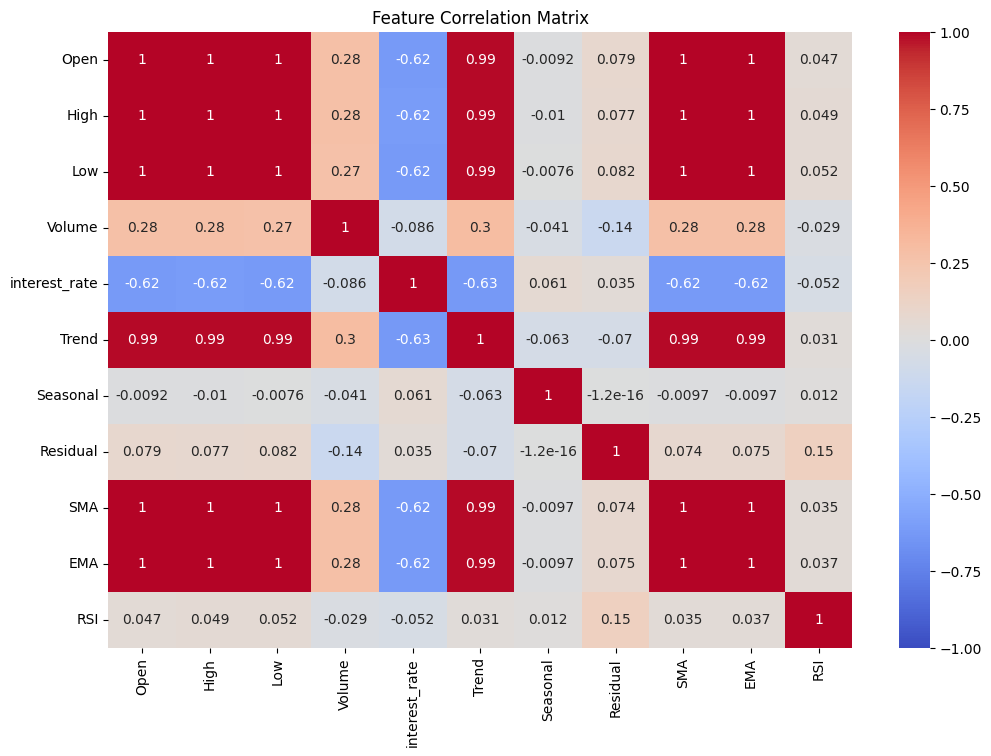

In [636]:
# Compute the correlation matrix
correlation_matrix = data[['Open','High','Low','Volume','interest_rate','Trend','Seasonal','Residual','SMA','EMA','RSI']].corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.show()